In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.fbprophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pickle

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [2]:
sales=pd.read_csv('y_df.csv')
sales.date= pd.to_datetime(sales.date)
sales = sales.set_index('date')
sales.head()

,total_sales
date,
2011-01-29,32631.0
2011-01-30,31749.0
2011-01-31,23783.0
2011-02-01,25412.0
2011-02-02,19146.0


In [3]:
y=sales['total_sales']
z=y.copy()

In [4]:
y.index=y.index.to_period("D")
y.index

PeriodIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
             '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
             '2011-02-06', '2011-02-07',
             ...
             '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
             '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
             '2016-05-21', '2016-05-22'],
            dtype='period[D]', name='date', length=1941, freq='D')

In [5]:
z.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [6]:
# fig, ax  = plot_series(y, labels =['sales'])
# fig.autofmt_xdate()

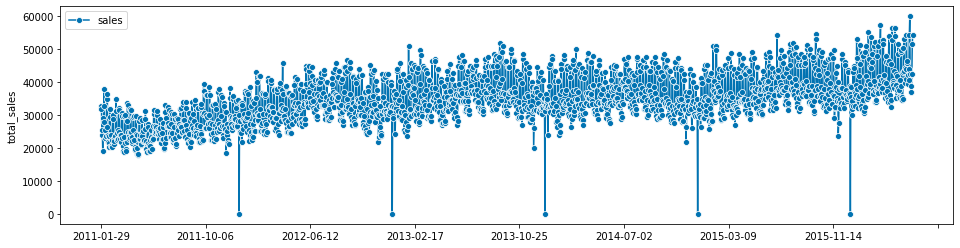

In [7]:
y=sales['total_sales']
plot_series(y, labels=['sales']);

In [8]:
cal=pd.read_csv('calendar.csv')

In [9]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


1913 28


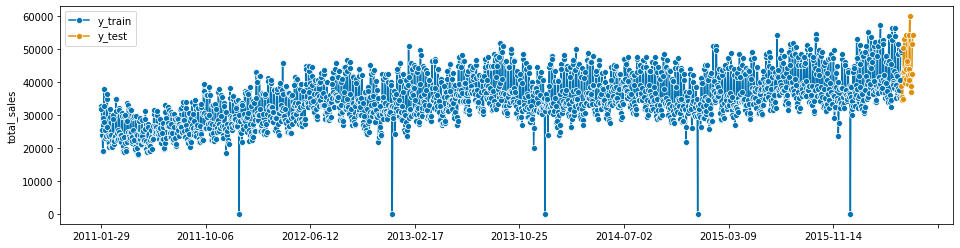

In [10]:
y_train, y_test = temporal_train_test_split(y, test_size=28)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

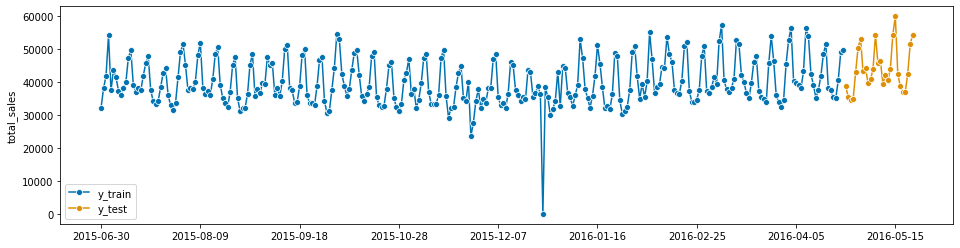

In [11]:
plot_series(y_train[-300:], y_test, labels=["y_train", "y_test"]);

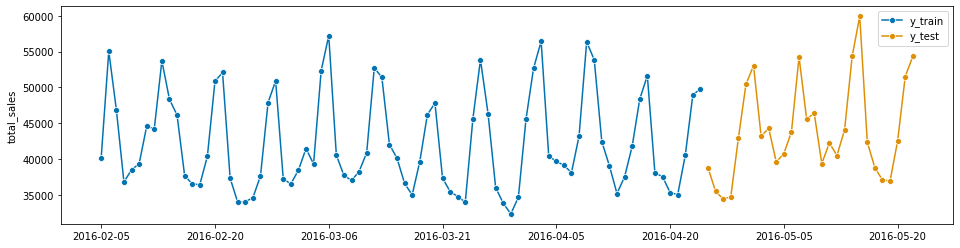

In [12]:
plot_series(y_train[-80:], y_test, labels=["y_train", "y_test"]);

In [13]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [14]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
             '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
             '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
             '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
             '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
             '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
             '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
            dtype='period[D]', name='date', freq='D', is_relative=False)

In [15]:
# save the model
def save_model(model_name):
    #print(model_name)
    filename = './Models/'+str(model_name)+'.pkl'
    pickle.dump(model_name, open(filename, 'wb'))

In [16]:
result=pd.DataFrame(columns=['model', 'smape_loss'])

In [17]:
def load_model(model_name, y_train, y_test, y_prediction):
    filename = './Models/'+str(model_name)+'.pkl'
    loaded_model = pickle.load(open(filename, 'rb'))
    plot_series(y_train[-40:], y_test, y_prediction, labels=["y_train", "y_test", "y_pred_"+str(model_name)])
    result=smape_loss(y_test, y_prediction)
    return result

## Naive baselines (Naive/ Seasonal Naive)

,model,smape_loss
1,naive,0.173581


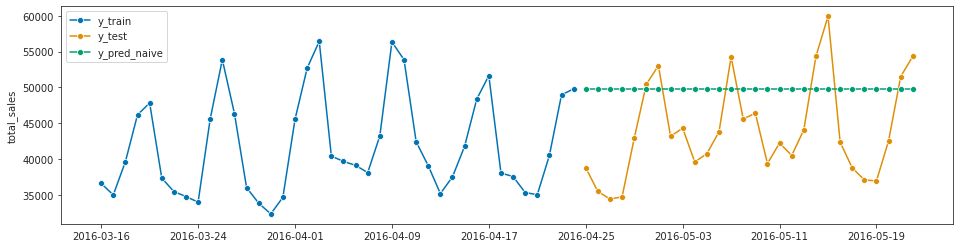

In [524]:
# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)
save_model('naive')
loss_naive=load_model('naive', y_train, y_test, y_pred_naive)
myindex = result.shape[0]+1 
result.at[myindex,'model']='naive'
result.at[myindex,'smape_loss']=loss_naive
result[result['model']=="naive"]

#### Predicting the last value of the same season

Wall time: 177 ms


,model,smape_loss
2,naive_last_season,0.087535


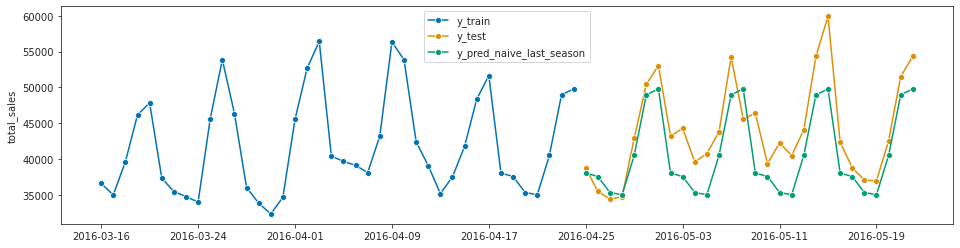

In [525]:
%%time
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred_last_season = forecaster.predict(fh)
save_model('naive_last_season')
loss_naive_last_season=load_model('naive_last_season', y_train, y_test, y_pred_last_season)
myindex = result.shape[0]+1 
result.at[myindex,'model']='naive_last_season'
result.at[myindex,'smape_loss']=loss_naive_last_season
result[result['model']=='naive_last_season']

## ExponentialSmoothing

C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Wall time: 1.19 s


,model,smape_loss
11,exponential,0.08931


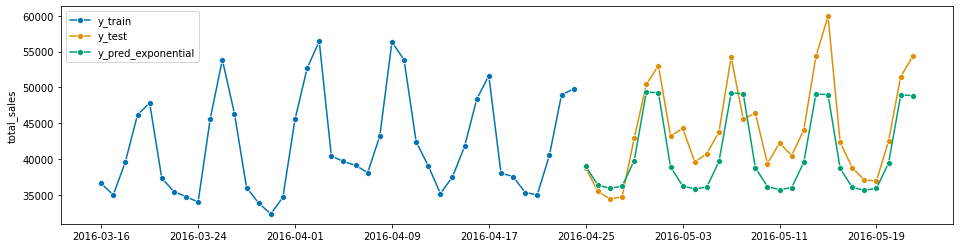

In [185]:
%%time
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=7)
forecaster.fit(y_train)
y_pred_exponential = forecaster.predict(fh)
#plot_series(y_train[-365:], y_test[-365:], y_pred, labels=["y_train", "y_test", "y_pred"])
#smape_loss(y_test, y_pred)
save_model('exponential')
loss_exponential=load_model('exponential', y_train, y_test, y_pred_exponential)
myindex = result.shape[0]+1 
result.at[myindex,'model']='exponential'
result.at[myindex,'smape_loss']=loss_exponential
result[result['model']=='exponential']

## AutoETS

Wall time: 6.35 s


,model,smape_loss
4,auto_ets,0.081176


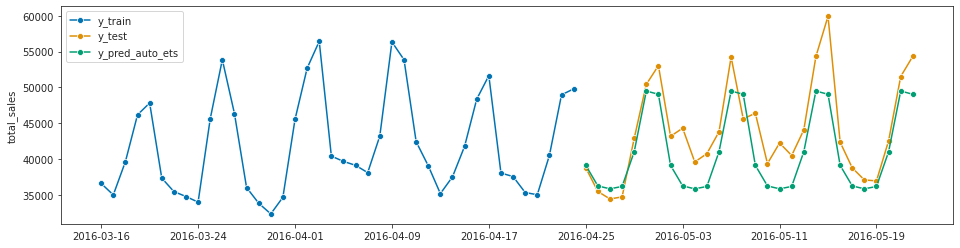

In [528]:
%%time
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=7, n_jobs=-1)
forecaster.fit(y_train)
y_pred_auto_ets = forecaster.predict(fh)
save_model('auto_ets')
loss_auto_ets=load_model('auto_ets', y_train, y_test, y_pred_auto_ets)

myindex = result.shape[0]+1 
result.at[myindex,'model']='auto_ets'
result.at[myindex,'smape_loss']=loss_auto_ets
result[result['model']=='auto_ets']

## Auto Arima

Wall time: 1min 57s


,model,smape_loss
5,autoarima,0.571929


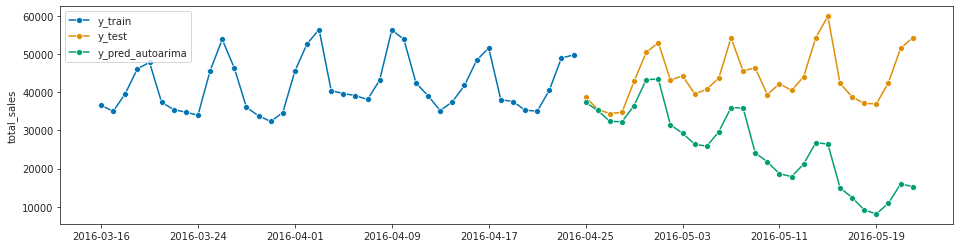

In [529]:
%%time
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(y_train)
y_pred_autoarima = forecaster.predict(fh)
save_model('autoarima')
loss_autoarima=load_model('autoarima', y_train, y_test, y_pred_autoarima)

myindex = result.shape[0]+1 
result.at[myindex,'model']='autoarima'
result.at[myindex,'smape_loss']=loss_autoarima
result[result['model']=='autoarima']

## BATS

Wall time: 2min 4s


,model,smape_loss
10,bats,0.070344


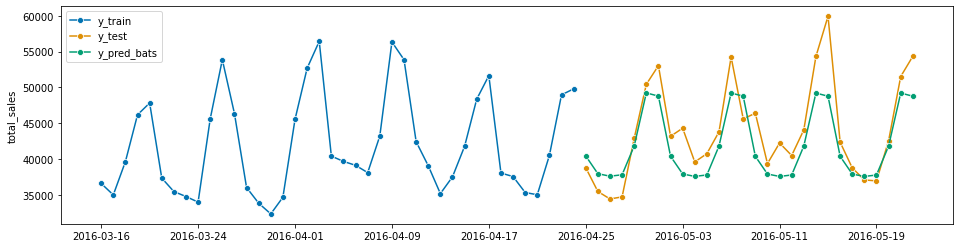

In [182]:
%%time
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred_bats = forecaster.predict(fh)
save_model('bats')
loss_bats= load_model('bats', y_train, y_test, y_pred_bats)

myindex = result.shape[0]+1 
result.at[myindex,'model']='bats'
result.at[myindex,'smape_loss']=loss_bats
result[result['model']=='bats']

## TBATS 

Wall time: 7min 49s


,model,smape_loss
7,tbats,0.072434


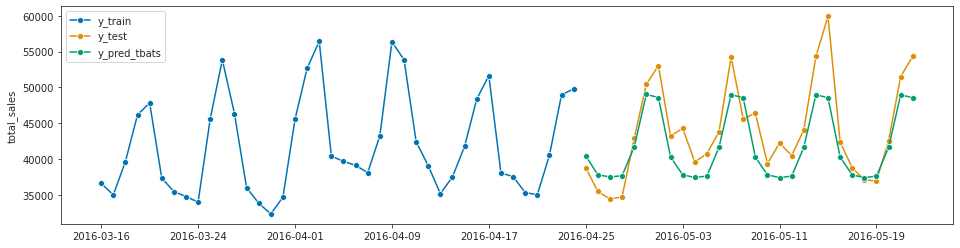

In [531]:
%%time
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred_tbats = forecaster.predict(fh)
save_model('tbats')
loss_tbats=load_model('tbats', y_train, y_test, y_pred_tbats)

myindex = result.shape[0]+1 
result.at[myindex,'model']='tbats'
result.at[myindex,'smape_loss']=loss_tbats
result[result['model']=='tbats']

## ThetaForecaster

,model,smape_loss
7,theta,0.080372
8,theta,0.080391
9,theta,0.080372


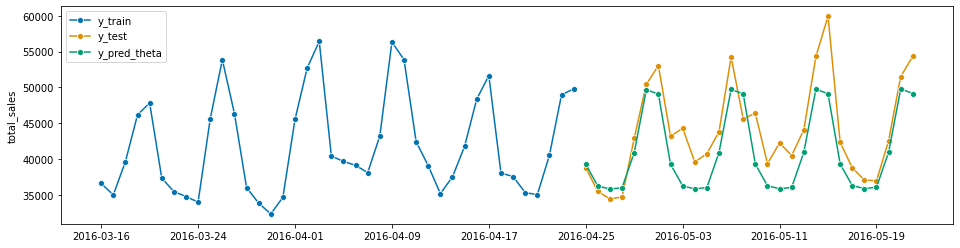

In [102]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=7)
forecaster.fit(y_train)
y_pred_theta = forecaster.predict(fh)
save_model('theta')
loss_theta=load_model('theta', y_train, y_test, y_pred_theta)

myindex = result.shape[0]+1 
result.at[myindex,'model']='theta'
result.at[myindex,'smape_loss']=loss_theta
result[result['model']=='theta']

## skprophet

In [24]:
def format_holidays(cal):
    df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': cal[~cal['event_name_1'].isna()]['date']})
    df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': cal[~cal['event_name_2'].isna()]['date']})
    df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': cal[cal['snap_CA'] == 1]['date']})
    df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': cal[cal['snap_TX'] == 1]['date']})
    df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': cal[cal['snap_WI'] == 1]['date']})
    holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return holidays
holidays = format_holidays(cal)

In [534]:
y.index

PeriodIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
             '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
             '2011-02-06', '2011-02-07',
             ...
             '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
             '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
             '2016-05-21', '2016-05-22'],
            dtype='period[D]', name='date', length=1941, freq='D')

In [25]:
# Convert index to pd.DatetimeIndex
z_train, z_test = temporal_train_test_split(z, test_size=28)

In [26]:
y_train

date
2011-01-29    32631.0
2011-01-30    31749.0
2011-01-31    23783.0
2011-02-01    25412.0
2011-02-02    19146.0
               ...   
2016-04-20    35343.0
2016-04-21    35033.0
2016-04-22    40517.0
2016-04-23    48962.0
2016-04-24    49795.0
Freq: D, Name: total_sales, Length: 1913, dtype: float64

In [537]:
y_train.reset_index()

,date,total_sales
0,2011-01-29,32631.0
1,2011-01-30,31749.0
2,2011-01-31,23783.0
3,2011-02-01,25412.0
4,2011-02-02,19146.0
...,...,...
1908,2016-04-20,35343.0
1909,2016-04-21,35033.0
1910,2016-04-22,40517.0
1911,2016-04-23,48962.0


In [127]:
z_test.index.freq='D'

In [128]:
fh_p = np.arange(len(z_test)) + 1
fh_p = ForecastingHorizon(z_test.index, is_relative=False)

In [129]:
fh_p

ForecastingHorizon(['2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
               '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
               '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
               '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
               '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
               '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', freq='D', is_relative=False)

,model,smape_loss
1,prophet,0.046495


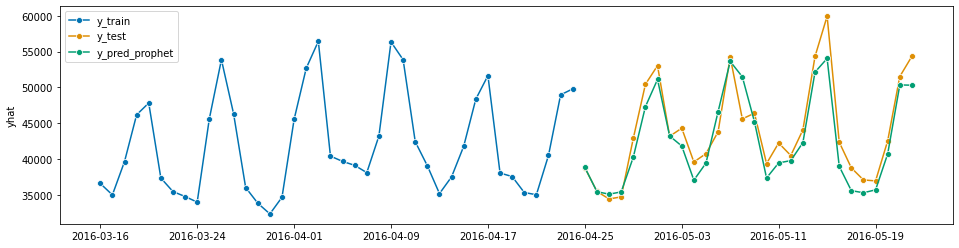

In [30]:
sk_forecaster = Prophet(seasonality_mode='multiplicative', 
                holidays=holidays,
                n_changepoints=2,
                changepoint_range=0.9,
                daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True
                )
sk_forecaster.fit(z_train)
y_pred_prophet = sk_forecaster.predict(fh_p)
y_pred_prophet.index = y_test.index
save_model('prophet')
loss_prophet=load_model('prophet', y_train, y_test, y_pred_prophet)
# plot_series(y_train[-40:], y_test, y_pred_prophet, labels=["y_train", "y_test", "y_pred_prophet"])
# smape_loss(y_test, y_prediction)

myindex = result.shape[0]+1 
result.at[myindex,'model']='prophet'
result.at[myindex,'smape_loss']=loss_prophet
result[result['model']=='prophet']

,model,smape_loss
2,prophet2,0.031872


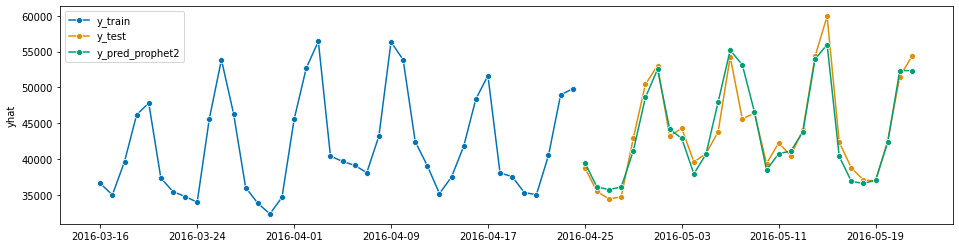

In [46]:
sk_forecaster2 = Prophet(seasonality_mode='multiplicative', 
                holidays=holidays,
                n_changepoints=2,
                changepoint_range=0.95,
                changepoint_prior_scale=0.1,
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                daily_seasonality=True, 
                weekly_seasonality=True,
                yearly_seasonality=True
                )
sk_forecaster2.fit(z_train)
y_pred_prophet2 = sk_forecaster2.predict(fh_p)
y_pred_prophet2.index = y_test.index
save_model('prophet2')
loss_prophet2=load_model('prophet2', y_train, y_test, y_pred_prophet2)
# plot_series(y_train[-40:], y_test, y_pred_prophet, labels=["y_train", "y_test", "y_pred_prophet"])
# smape_loss(y_test, y_prediction)

myindex = result.shape[0]+1 
result.at[myindex,'model']='prophet2'
result.at[myindex,'smape_loss']=loss_prophet2
result[result['model']=='prophet2']

In [46]:
int(len(y_train) * 0.5)

956

## Random Forest

,model,smape_loss
3,r_forest,0.060884


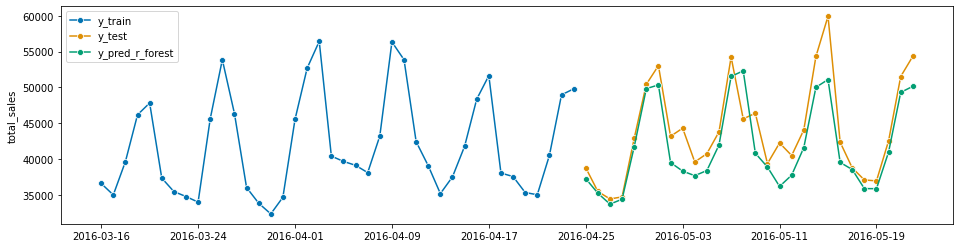

In [47]:


# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200]}
forecaster_param_grid = {"window_length": [40, 50, 60]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = ReducedForecaster(
    regressor, window_length=15, scitype='regressor',strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv_rf = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv_rf.fit(y_train)
y_pred_rf = gscv_rf.predict(fh)
# plot_series(y_train[-50:], y_test, y_pred_rf labels=["y_train", "y_test", "y_pred_rf"])
# smape_loss(y_test, y_pred_rf)

save_model('r_forest')
loss_rf=load_model('r_forest', y_train, y_test, y_pred_rf)

myindex = result.shape[0]+1 
result.at[myindex,'model']='r_forest'
result.at[myindex,'smape_loss']=loss_rf
result[result['model']=='r_forest']

In [231]:
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 50} {'n_estimators': 100}


In [ ]:
forecaster = ReducedForecaster(
    RandomForestRegressor(n_estimators = 100), window_length=50, scitype='regressor',strategy="recursive"
)

In [ ]:
pd.DataFrame(gscv.cv_results_)

## XGBRRegressor and LGBMRegressor

In [50]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [58]:
%%time
xgb = XGBRegressor()
lgb = LGBMRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
param_grid = {
    "window_length": [x for x in range(26, 30, 2)],
    "regressor": [xgb, lgb]
}

forecaster = ReducedForecaster(regressor=xgb,scitype='regressor')
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=sMAPE(),verbose=1)
gscv.fit(y_train)
results = pd.DataFrame(gscv.cv_results_)



Fitting 1913 folds for each of 4 candidates, totalling 7652 fits
Wall time: 1min 40s


,mean_fit_time,mean_score_time,param_regressor,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,0.662228,25.973675,"XGBRegressor(base_score=None, booster=None, co...",26,"{'regressor': XGBRegressor(base_score=None, bo...",0.074276,4
1,0.707106,23.959408,"XGBRegressor(base_score=None, booster=None, co...",28,"{'regressor': XGBRegressor(base_score=None, bo...",0.070920,3
2,0.360035,23.786707,LGBMRegressor(),26,"{'regressor': LGBMRegressor(), 'window_length'...",0.067766,2
3,0.361032,23.870626,LGBMRegressor(),28,"{'regressor': LGBMRegressor(), 'window_length'...",0.064309,1


In [32]:
gscv.best_params_

{'regressor': LGBMRegressor(), 'window_length': 28}

In [60]:
forecaster = ReducedForecaster(regressor=lgb,scitype='regressor', window_length = 28)
forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

In [81]:
%%time

lgb = LGBMRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))

lgb_params_grid = {
    'num_leaves': [25, 40, 50],
    'learning_rate': [0.1, 0.01],
    'max_depth': [-1, 2, 5],
    'n_estimators': [40, 50, 100]
}

gscv_param_grid = {
    "window_length": [20, 67, 68]
}

regressor = GridSearchCV(lgb, param_grid=lgb_params_grid)
                         
forecaster = ReducedForecaster(regressor,scitype='regressor')

lgb_gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=gscv_param_grid, scoring=sMAPE())
lgb_gscv.fit(y_train)
# lgb_results = pd.DataFrame(lgb_gscv.cv_results_)
# lgb_results

Wall time: 3min 10s


,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,16.501195,24.504537,20,{'window_length': 20},0.071799,3
1,29.094606,23.077064,67,{'window_length': 67},0.063918,1
2,27.212574,24.283325,68,{'window_length': 68},0.066315,2


In [82]:
print(lgb_gscv.best_params_, lgb_gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 67} {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 40}


,model,smape_loss
4,lgbm,0.057895


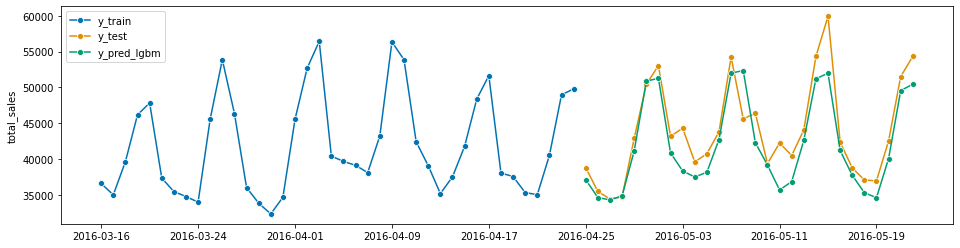

In [94]:

y_pred_lgbm = lgb_gscv.predict(fh)

save_model('lgbm')
loss_lgbm=load_model('lgbm', y_train, y_test, y_pred_lgbm)

myindex = result.shape[0]+1 
result.at[myindex,'model']='lgbm'
result.at[myindex,'smape_loss']=loss_lgbm
result[result['model']=='lgbm']

In [86]:
%%time

xgb = XGBRegressor()

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))

xgb_params_grid = {
 
    'learning_rate': [0.1, 0.01],
    'max_depth': [-1, 2, 5,],
    'n_estimators': [50, 100]
}

gscv_param_grid = {
    "window_length": [75, 80, 90]
}

regressor = GridSearchCV(xgb, param_grid=xgb_params_grid)
                         
forecaster = ReducedForecaster(regressor,scitype='regressor')

xgb_gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=gscv_param_grid, scoring=sMAPE())
xgb_gscv.fit(y_train)
xgb_results = pd.DataFrame(xgb_gscv.cv_results_)
xgb_results

C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\sklearn.py", line 597, in fit
    self._Booster = train(params, train_dmatrix,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\c

C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fast6\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\sklearn.py", line 597, in fit
    self._Booster = train(params, train_dmatrix,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\fast6\anaconda3\lib\site-packages\xgboost\c

Wall time: 4min 14s


,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,23.123692,43.420571,75,{'window_length': 75},0.068693,3
1,25.296009,43.111672,80,{'window_length': 80},0.063181,1
2,26.513591,45.986626,90,{'window_length': 90},0.066653,2


In [87]:
print(xgb_gscv.best_params_, xgb_gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 80} {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


,model,smape_loss
5,xgb,NaN
6,xgb,0.067767


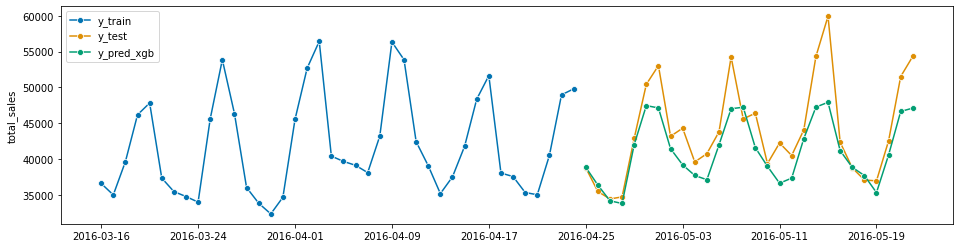

In [96]:

y_pred_xgb = xgb_gscv.predict(fh)

save_model('xgb')
loss_xgb=load_model('xgb', y_train, y_test, y_pred_xgb)

myindex = result.shape[0]+1 
result.at[myindex,'model']='xgb'
result.at[myindex,'smape_loss']=loss_xgb
result[result['model']=='xgb']

C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0.06276440716554925

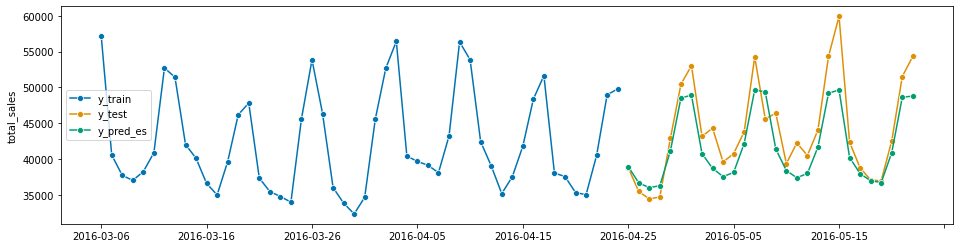

In [184]:
# sktime ensembler
forecaster = EnsembleForecaster([
        ('theta_ses', ThetaForecaster(sp=7)),
        ('theta', ThetaForecaster()),
        ("exp_ses", ExponentialSmoothing(seasonal="multiplicative", sp=7)),
        ("exp_damped", ExponentialSmoothing(trend='multiplicative', damped_trend=True, seasonal="multiplicative", sp=7)),
        #("bats", BATS(sp=7, use_trend=True, use_box_cox=False)),
        ("prophet",  Prophet(seasonality_mode='multiplicative', 
                        holidays=holidays,
                        n_changepoints=2,
                        changepoint_range=0.95,
                        changepoint_prior_scale=0.1,
                        seasonality_prior_scale=10,
                        holidays_prior_scale=10,
                        daily_seasonality=True, 
                        weekly_seasonality=True,
                        yearly_seasonality=True
                        )),
        ("lgbm", ReducedForecaster(LGBMRegressor(learning_rate = 0.1,
                            max_depth = -1, 
                            n_estimators = 50, 
                            num_leaves = 40),
                        scitype='regressor', 
                        window_length = 67
                            )),
        ("xgb", ReducedForecaster(XGBRegressor(learning_rate = 0.1,
                            max_depth = 2, 
                            n_estimators = 50),
                        scitype='regressor',
                        window_length = 80
                            )),
         ("r_forest", ReducedForecaster(RandomForestRegressor(n_estimators = 100), 
                             window_length=50, scitype='regressor',strategy="recursive"))
    ])

forecaster.fit(z_train)
y_pred = forecaster.predict(fh_p)
y_pred_es= y_pred.copy()
y_pred_es.index = y_pred.index.to_period()
plot_series(y_train[-50:], y_test, y_pred_es, labels=["y_train", "y_test", "y_pred_es"])
smape_loss(y_test, y_pred_es)

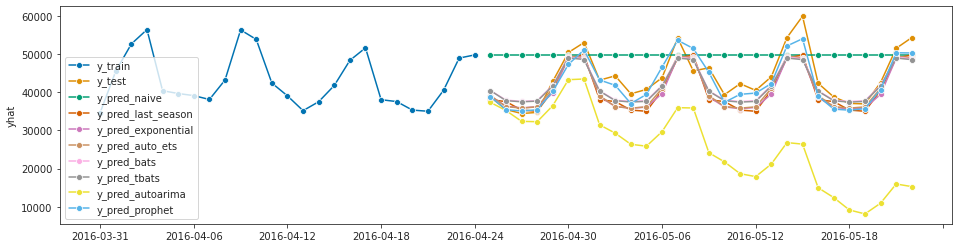

In [543]:
plot_series(y_train[-25:], y_test, y_pred_naive,y_pred_last_season, y_pred_exponential,y_pred_auto_ets,
            y_pred_bats,y_pred_tbats,y_pred_autoarima,y_pred_prophet,
            labels=["y_train", "y_test", "y_pred_naive","y_pred_last_season", "y_pred_exponential", "y_pred_auto_ets", 
                    "y_pred_bats","y_pred_tbats", "y_pred_autoarima", "y_pred_prophet"]);

In [544]:
result=result.sort_values('smape_loss',ignore_index=True)
#result=result.style.apply(highlight_max)
result

,model,smape_loss
0,prophet,0.046495
1,bats,0.070344
2,tbats,0.072434
3,auto_ets,0.081176
4,naive_last_season,0.087535
5,exp_smoothng,0.08931
6,naive,0.173581
7,autoarima,0.571929


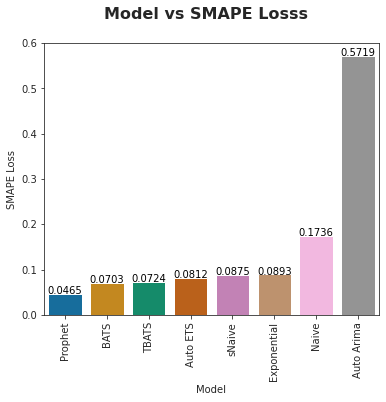

In [553]:
import matplotlib.pyplot as plt
%matplotlib inline
fig_dims = (6, 5)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Model vs SMAPE Losss', fontsize = 16, weight = 'bold')

ax=sns.barplot(x = 'model', y = 'smape_loss', data=result);
ax.set_xlabel('Model')
ax.set_ylabel('SMAPE Loss')
ax.set_xticklabels(['Prophet','BATS','TBATS','Auto ETS','sNaive','Exponential' ,'Naive' ,'Auto Arima'], rotation='vertical', fontsize=10)
for index, row in result.iterrows():
    ax.text(row.name,row.smape_loss, round(row.smape_loss,4), color='black', ha="center")
plt.show()